In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, IterableDataset
from torch.utils.data import DataLoader

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from collections import Counter

import math, random

import os

from typing import Sequence, Optional, Callable, List, Dict

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

import unicodedata
import string

from copy import deepcopy

from modelSGNS import SkipGramModel
from dataSet import SGNS_store_DataSet
from visuEmbedding import interactive_embedding_plot_3D, components_to_fig_3D, components_to_fig_3D_animation

# torch.manual_seed(1)systemd

device = 'cpu'

[nltk_data] Downloading package punkt_tab to /home/pe/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
def cosine_similarity_matrix(embeddings:nn.Embedding) -> torch.Tensor:
    emb = embeddings.weight.detach()
    emb_norm = F.normalize(emb, p=2, dim=1)
    similarity_matrix = emb_norm @ emb_norm.t()
    return similarity_matrix

def update_sim_history(words: list[str], idx: List[int], cos_sim_history:Dict, similarity_matrix):
    num_words = len(words)

    for i in range(num_words):
        for j in range(num_words):
            similarity = ((similarity_matrix[idx[i], idx[j]] + 1) / 2) * 100
            cos_sim_history[words[i]][words[j]].append(round(float(similarity), 2))

def heat_map(words:List[str], similarity_matrix, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="magma",
                xticklabels=words, yticklabels=words, cbar=True, robust=False,
                vmin=0, vmax=100,
                square=False, linewidths=0.)

    plt.title("Heatmap de Similarité Cosinus")
    plt.xlabel("Mots", fontstyle="italic")
    plt.ylabel("Mots", fontstyle="italic")
    plt.savefig("tmp.png")
    plt.show()

In [3]:
# Mots central, similaire et différent
data1 = ['peluche', 'train', ['chat', 'chien', 'souris']]
data5 = ['train', 'peluche', ['chat', 'chien', 'souris']]

data2 = ['chat', 'chien', ['peluche', 'train']]
data3 = ['chat', 'souris', ['peluche', 'train']]
data4 = ['chien', 'souris', ['peluche', 'train']]

encoder = {
    'peluche' : 0,
    'train' : 1,
    'chat' : 2,
    'chien' : 3,
    'souris': 4
}

nb_word = 5
list_data = [data1, data2, data5, data3, data4] * 20

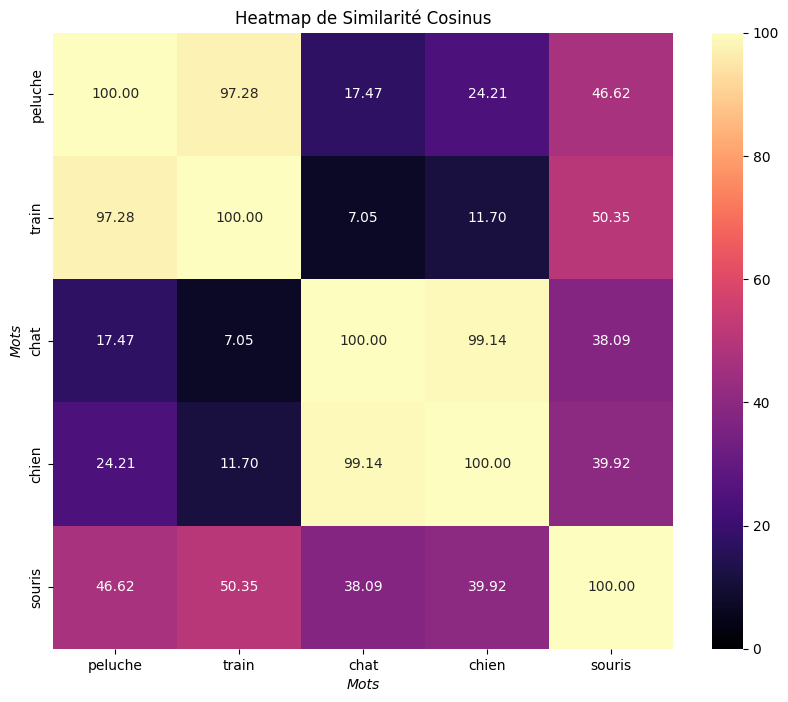

In [4]:
modelW2V:SkipGramModel = SkipGramModel(nb_word, embedding_dimension=3, sparse=False, init_range=1)
# optimizer = torch.optim.SparseAdam(modelW2V.parameters(), lr=0.01)
optimizer = torch.optim.Adam(modelW2V.parameters(), lr=0.02)


loss_history = []
epoch_loss = 0

all_cos_sim = {}

for w1 in encoder.keys():
    all_cos_sim[w1] = {}
    for w2 in encoder.keys():
        all_cos_sim[w1][w2] = []


modelW2V.train()
emb_history = []
for _ in range(10):
    for centers, pos, negs in list_data:
        centers = torch.tensor(encoder[centers]).unsqueeze(dim=-1)
        pos = torch.tensor(encoder[pos]).unsqueeze(dim=-1)
        negs = torch.tensor([encoder[w] for w in negs]).unsqueeze(dim=0)

        pos = pos
        negs = negs

        optimizer.zero_grad()
        loss = modelW2V(centers, pos, negs)
        loss.backward()

        optimizer.step()

        batch_loss = loss.item()
        epoch_loss += batch_loss
        loss_history.append(batch_loss)

        k = list(encoder.keys())
        v = list(encoder.values())
        
        matrix_sim = cosine_similarity_matrix(modelW2V.word_emb)
        update_sim_history(words=k, idx=v, cos_sim_history=all_cos_sim, similarity_matrix=matrix_sim)
        w = deepcopy(modelW2V.word_emb.weight.detach().cpu().numpy())
        emb_history.append(w)


k = list(encoder.keys())
idx = list(encoder.values())
m_to_h = matrix_sim.detach().numpy()
m_to_h_2 = m_to_h[idx,:]
m_to_h_2 = m_to_h_2[:, idx]

m_to_h_2 = (m_to_h_2 + 1) / 2 * 100
heat_map(k, m_to_h_2)

In [5]:
base_colors = {
    'chat': ("blue",  "cyan"),
    'peluche': ("green", "lightgreen"),
}


fig = components_to_fig_3D_animation(
    history_components=emb_history[-2:-1],
    encoder=encoder,
    words_display=list(encoder.keys()),
    highlight_words=["chat", "peluche"],
    nb_neighbors=2, _min=-5, _max=5, base_color=base_colors
)

In [6]:
print(all_cos_sim['train']['peluche'])
print(all_cos_sim['chat']['chien'])


[24.88, 25.08, 24.25, 23.9, 23.79, 24.01, 24.29, 25.65, 26.82, 27.82, 28.9, 29.85, 31.45, 32.82, 34.01, 35.24, 36.34, 37.77, 39.01, 40.09, 41.25, 42.28, 43.51, 44.58, 45.51, 46.57, 47.5, 48.56, 49.49, 50.31, 51.28, 52.14, 53.08, 53.91, 54.65, 55.56, 56.37, 57.23, 58.0, 58.68, 59.54, 60.31, 61.11, 61.83, 62.46, 63.28, 64.0, 64.76, 65.43, 66.02, 66.78, 67.46, 68.17, 68.79, 69.34, 70.05, 70.68, 71.33, 71.91, 72.41, 73.07, 73.64, 74.24, 74.76, 75.22, 75.81, 76.34, 76.87, 77.35, 77.76, 78.3, 78.76, 79.24, 79.67, 80.04, 80.51, 80.92, 81.35, 81.72, 82.05, 82.47, 82.83, 83.2, 83.53, 83.82, 84.18, 84.5, 84.82, 85.1, 85.36, 85.67, 85.94, 86.22, 86.46, 86.68, 86.95, 87.18, 87.42, 87.63, 87.82, 88.04, 88.24, 88.45, 88.63, 88.79, 88.98, 89.15, 89.32, 89.47, 89.61, 89.77, 89.92, 90.06, 90.19, 90.31, 90.45, 90.57, 90.69, 90.81, 90.9, 91.02, 91.13, 91.23, 91.33, 91.41, 91.51, 91.6, 91.69, 91.77, 91.85, 91.93, 92.01, 92.09, 92.16, 92.22, 92.29, 92.36, 92.43, 92.49, 92.54, 92.61, 92.67, 92.73, 92.78, 92

In [7]:
def pipe_data(
    language: str,
    dataseteur: Callable[..., object],
    window_size: int = 3,
    nb_neg: int = 3,
    subsample_thresh: float = 1.0,
    vocab_size_limit: Optional[int] = None,
    power:float =0.75,
    file: Optional[str] = None,
    files: Optional[list[str]] = None,
    sentences: Optional[List[List[str]]] = None,
    remove_accent: bool = True,
    remove_ponct: bool = True,
    keep_accent: bool = True,
    contraction_map: Optional[dict] = None,
) -> object:
    """
    """
    if contraction_map is None:
        contraction_map = {
            "n't": " n't", "'re": " 're", "'ve": " 've", "'ll": " 'll",
            "'d": " 'd", "'s": " 's", "'m": " 'm"
        }

    if all([(files is None), (file is None), (sentences is None)],):
        raise AssertionError("One of files, file or sentence must not be None")

    if language not in {"english", "french", None}:
        raise ValueError("language must be 'english' or 'french' or None")

    def remove_accents(text: str) -> str:
        nk = unicodedata.normalize("NFKD", text)
        return "".join(ch for ch in nk if not unicodedata.combining(ch))

    keep = {"'", "’"} if keep_accent else set()
    base_punct = set(string.punctuation)
    extra_punct = set('“”‘’—–…«»')
    punct_to_remove = (base_punct | extra_punct) - keep
    TRANSL_TABLE = str.maketrans('', '', ''.join(sorted(punct_to_remove)))

    tokens_by_sentence: List[List[str]] = []

    if files is not None:
        for name_file in files:
            with open(name_file, encoding="utf-8") as f:
                for line in f:
                    s = line.strip().lower()
                    if not s:
                        continue
                    if remove_accent:
                        s = remove_accents(s)
                    for k, v in contraction_map.items():
                        s = s.replace(k, v)
                    if remove_ponct:
                        s = s.translate(TRANSL_TABLE)
                    s = " ".join(s.split())
                    toks = word_tokenize(s, language=language)
                    if toks:
                        tokens_by_sentence.append(toks)

    elif file is not None:
        with open(file, encoding="utf-8") as f:
            for line in f:
                s = line.strip().lower()
                if not s:
                    continue
                if remove_accent:
                    s = remove_accents(s)
                for k, v in contraction_map.items():
                    s = s.replace(k, v)
                if remove_ponct:
                    s = s.translate(TRANSL_TABLE)
                s = " ".join(s.split())
                if not s:
                    continue
                toks = word_tokenize(s, language=language)
                if toks:
                    tokens_by_sentence.append(toks)
    else:
        tokens_by_sentence = [list(s) for s in sentences if s]

    return dataseteur(
        sentences=tokens_by_sentence,
        window_size=window_size,
        nb_neg=nb_neg,
        subsample_thresh=subsample_thresh,
        power=power,
        vocab_size_limit=vocab_size_limit
    )

In [26]:
dataset:SGNS_store_DataSet = pipe_data(
    language="french",
    dataseteur=SGNS_store_DataSet,
    window_size = 5,
    nb_neg=10,
    subsample_thresh= 1,
    vocab_size_limit=None,
    file="data/GPT5v2.txt",
    # files=["data/chat_chien.txt", "data/toy.txt"],
    remove_accent=True,
    remove_ponct=True,
    keep_accent= False,
    contraction_map=None
)

print(dataset[0])
data = DataLoader(dataset, batch_size=1, shuffle=False)

(tensor(0), tensor(1), tensor([32, 18,  6, 41,  1, 37, 18,  6, 55, 30]))


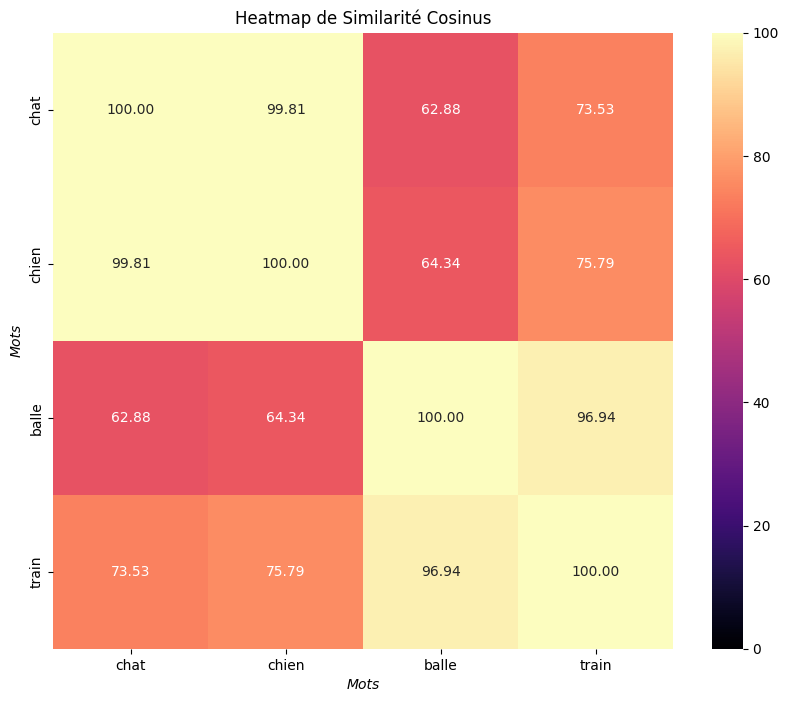

In [27]:
modelW2V:SkipGramModel = SkipGramModel(dataset.vocab_size, embedding_dimension=3, init_range=1, sparse=True)
# optimizer = torch.optim.Adam(modelW2V.parameters(), lr=0.01)
# optimizer = torch.optim.AdamW(modelW2V.parameters(), lr=0.01)
optimizer = torch.optim.SparseAdam(modelW2V.parameters(), lr=0.01)
# optimizer = torch.optim.SGD(modelW2V.parameters(), lr=0.01, weight_decay=None)


all_cos_sim = {}

for w1 in dataset.encoder.keys():
    all_cos_sim[w1] = {}
    for w2 in dataset.encoder.keys():
        all_cos_sim[w1][w2] = []

modelW2V.train()

k = ['chat', 'chien', 'balle', 'train']
v = dataset.encode(k)

emb_history = []
for _ in range(30):
    w = deepcopy(modelW2V.word_emb.weight.detach().cpu().numpy())
    emb_history.append(w)
    for sentence_nb, (centers, pos, negs) in enumerate(data):
        optimizer.zero_grad()
        loss = modelW2V(centers, pos, negs)
        loss.backward()

        optimizer.step()

        batch_loss = loss.item()
        epoch_loss += batch_loss
        loss_history.append(batch_loss)
       
        matrix_sim = cosine_similarity_matrix(modelW2V.word_emb)
        update_sim_history(words=k, idx=v, cos_sim_history=all_cos_sim, similarity_matrix=matrix_sim)

        
k = ['chat', 'chien', 'balle', 'train']
m_to_h = matrix_sim.detach().numpy()
m_to_h_2 = m_to_h[dataset.encode(k),:]
m_to_h_2 = m_to_h_2[:, dataset.encode(k)]

m_to_h_2 = (m_to_h_2 + 1) / 2 * 100
heat_map(k, m_to_h_2)

In [10]:
k = ['le', 'les', 'et', 'train']

base_colors = {
    'le': ("red",   "orange"),
    'chien': ("blue",  "cyan"),
    'balle': ("green", "lightgreen"),
    'train': ("purple","violet"),
    'chat': ("brown", "peru"),
    'et': ("magenta","pink"),
}

fig = components_to_fig_3D_animation(
    history_components=emb_history,
    encoder=dataset.encoder,
    words_display=list(dataset.encoder.keys()),
    highlight_words=k, base_color=base_colors,
    nb_neighbors=6, _min=-5, _max=5
)

In [11]:
print(all_cos_sim['train']['balle'])
print(all_cos_sim['chat']['chien'])

[33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.8, 33.

In [12]:
contraction_map = {
    "n't": " n't", "'re": " 're", "'ve": " 've", "'ll": " 'll",
    "'d": " 'd", "'s": " 's", "'m": " 'm"
}

def remove_accents(text: str) -> str:
    nk = unicodedata.normalize("NFKD", text)
    return "".join(ch for ch in nk if not unicodedata.combining(ch))

keep = {"'", "’"}
base_punct = set(string.punctuation)
extra_punct = set('“”‘’—–…«»')
punct_to_remove = (base_punct | extra_punct) - keep
TRANSL_TABLE = str.maketrans('', '', ''.join(sorted(punct_to_remove)))

tokens_by_sentence: List[List[str]] = []

stop_words = ["le", "les", "sur", "jouer", "fait", "de", "et", "la", "des", "sont"]

with open("data/GPT5v2.txt", encoding="utf-8") as f:
    for line in f:
        s = line.strip().lower()
        if not s:
            continue
        s = remove_accents(s)
        s = s.translate(TRANSL_TABLE)
        s2 = [word for word in s.split() if word not in stop_words]
        s = " ".join(s2)

        toks = word_tokenize(s, language="french")

        if toks:
            tokens_by_sentence.append(toks)

dataset:SGNS_store_DataSet=SGNS_store_DataSet(tokens_by_sentence, 3, 10, power=1, subsample_thresh=1)
data = DataLoader(dataset, batch_size=1, shuffle=False)


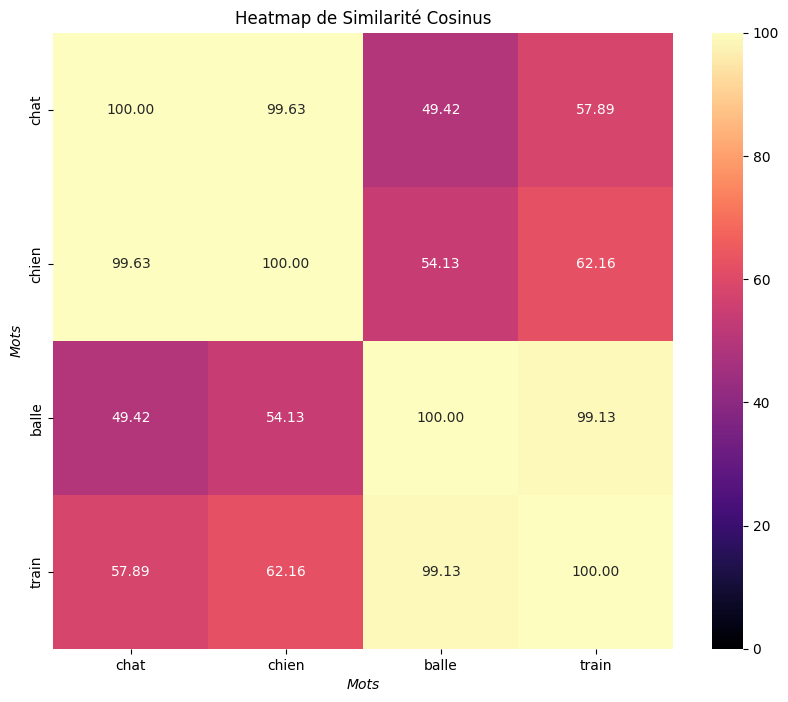

In [ ]:
modelW2V:SkipGramModel = SkipGramModel(dataset.vocab_size, embedding_dimension=3, init_range=1, sparse=False)
optimizer = torch.optim.Adam(modelW2V.parameters(), lr=0.01)
# optimizer = torch.optim.AdamW(modelW2V.parameters(), lr=0.01)
# optimizer = torch.optim.SparseAdam(modelW2V.parameters(), lr=0.1)
# optimizer = torch.optim.SGD(modelW2V.parameters(), lr=0.01, weight_decay=None)


all_cos_sim = {}

for w1 in dataset.encoder.keys():
    all_cos_sim[w1] = {}
    for w2 in dataset.encoder.keys():
        all_cos_sim[w1][w2] = []

modelW2V.train()

k = ['chat', 'chien', 'balle', 'train']
v = dataset.encode(k)

emb_history = []
emb_con_history = []

nb_epoch = 30
for _ in range(nb_epoch):
    w = deepcopy(modelW2V.word_emb.weight.detach().cpu().numpy())
    emb_history.append(w)

    w = deepcopy(modelW2V.con_emb.weight.detach().cpu().numpy())
    emb_con_history.append(w)

    for sentence_nb, (centers, pos, negs) in enumerate(data):
        optimizer.zero_grad()
        loss = modelW2V(centers, pos, negs)
        loss.backward()

        optimizer.step()
       
        matrix_sim = cosine_similarity_matrix(modelW2V.word_emb)
        update_sim_history(words=k, idx=v, cos_sim_history=all_cos_sim, similarity_matrix=matrix_sim)


k = ['chat', 'chien', 'balle', 'train']
m_to_h = matrix_sim.detach().numpy()
m_to_h_2 = m_to_h[dataset.encode(k),:]
m_to_h_2 = m_to_h_2[:, dataset.encode(k)]

m_to_h_2 = (m_to_h_2 + 1) / 2 * 100
heat_map(k, m_to_h_2)

In [14]:
k = ['chat', 'chien', 'balle', 'train']

base_colors = {
    'le': ("red",   "orange"),
    'chien': ("blue",  "cyan"),
    'balle': ("green", "lightgreen"),
    'train': ("purple","violet"),
    'chat': ("brown", "peru"),
    'et': ("magenta","pink"),
}
fig = components_to_fig_3D(
    components=emb_history[-1],
    encoder=dataset.encoder, words_display=None,
    highlight_words=k, base_color=base_colors,
    nb_neighbors=6, _min=-5, _max=5
)
fig.show()


fig2 = components_to_fig_3D(
    components=emb_con_history[-1],
    encoder=dataset.encoder, words_display=None,
    highlight_words=k, base_color=base_colors,
    nb_neighbors=6, _min=-5, _max=5
)
fig2.show()


In [15]:
tab_emb = np.array(emb_history[-1])

In [19]:
def analyser_anisotropie(embeddings):
    """
    Analyse la distribution des vecteurs d'embedding.
    Args:
        embeddings: np.array de forme (n_samples, n_features)
    """

    # Here we are interesting by the direction of vector, so we can (and must) normalize each vector to have same distance
    normes = np.linalg.norm(embeddings, axis=1, keepdims=True)
    embeddings_norm = embeddings / (normes + 1e-10)

    # Compute cosine similarity
    sim_matrix = cosine_similarity(embeddings_norm)

    # Keep only one result for each pair of cosine
    indices = np.triu_indices_from(sim_matrix, k=1)
    mean_cosine = np.mean(sim_matrix[indices])
    
    print(f"Cosine similarity (mean) : {mean_cosine:.4f}")

    pca = PCA(n_components=min(embeddings.shape[0], embeddings.shape[1]))
    pca.fit(embeddings_norm)
    
    explained_var = pca.explained_variance_ratio_
    print(f"Ratio de variance expliquée () : {explained_var}")
    

    mean_vector = np.mean(embeddings_norm, axis=0)
    norm_mean_vector = np.linalg.norm(mean_vector)
    
    print(f"Norme du vecteur moyen (0=isotrope, 1=aligné) : {norm_mean_vector:.4f}")


# analyser_anisotropie(emb_history[-1])

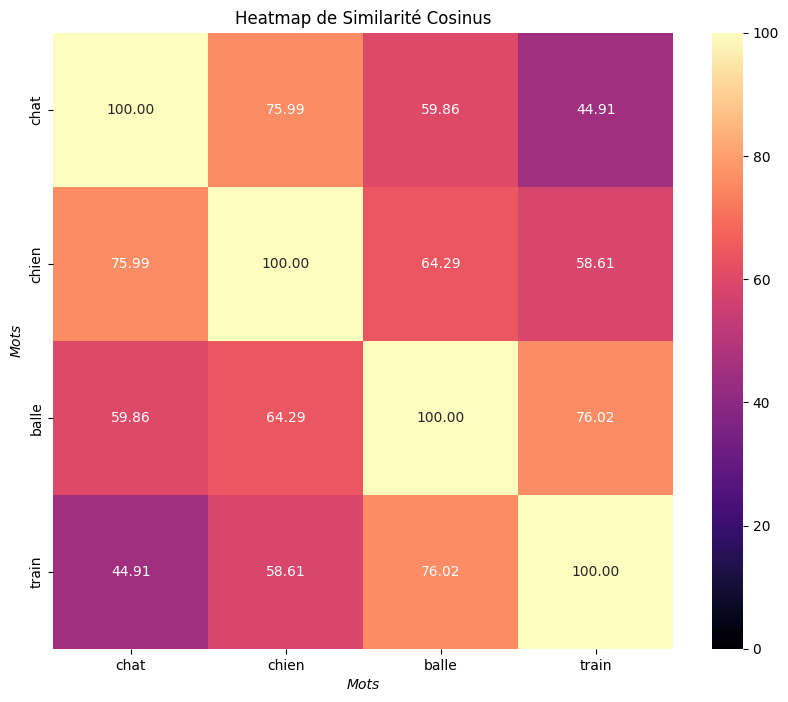

Cosine similarity (mean) : 0.4630
Ratio de variance expliquée () : [0.1754073  0.10534457 0.0954444  0.08538121 0.0835658  0.07256248
 0.06262802 0.05666562 0.05428541 0.04878562 0.04188268 0.04133304
 0.03745456 0.03617667 0.00308266]
Norme du vecteur moyen (0=isotrope, 1=aligné) : 0.6854


In [20]:
modelW2V:SkipGramModel = SkipGramModel(dataset.vocab_size, embedding_dimension=15, init_range=1, sparse=False)
optimizer = torch.optim.Adam(modelW2V.parameters(), lr=0.01)

all_cos_sim = {}

for w1 in dataset.encoder.keys():
    all_cos_sim[w1] = {}
    for w2 in dataset.encoder.keys():
        all_cos_sim[w1][w2] = []

modelW2V.train()

k = ['chat', 'chien', 'balle', 'train']
v = dataset.encode(k)

nb_epoch = 30
for _ in range(nb_epoch):
    for sentence_nb, (centers, pos, negs) in enumerate(data):
        optimizer.zero_grad()
        loss = modelW2V(centers, pos, negs)
        loss.backward()

        optimizer.step()
       
        matrix_sim = cosine_similarity_matrix(modelW2V.word_emb)
        update_sim_history(words=k, idx=v, cos_sim_history=all_cos_sim, similarity_matrix=matrix_sim)

k = ['chat', 'chien', 'balle', 'train']
m_to_h = matrix_sim.detach().numpy()
m_to_h_2 = m_to_h[dataset.encode(k),:]
m_to_h_2 = m_to_h_2[:, dataset.encode(k)]

m_to_h_2 = (m_to_h_2 + 1) / 2 * 100
heat_map(k, m_to_h_2)



In [22]:
analyser_anisotropie(modelW2V.word_emb.weight.detach().cpu().numpy())

Cosine similarity (mean) : 0.2898
Ratio de variance expliquée () : [0.17299691 0.1223968  0.1045195  0.08997851 0.0847967  0.0689072
 0.06233162 0.05689581 0.04723767 0.04212734 0.03893991 0.0378418
 0.03430459 0.03217481 0.0045507 ]
Norme du vecteur moyen (0=isotrope, 1=aligné) : 0.5466


In [28]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import skew

def analyser_anisotropie_advanced(embeddings, max_samples=10000):
    """
    Advanced anisotropy analysis with mathematical fixes and PC alignment.
    
    Args:
        embeddings: np.array (n_samples, n_features)
        max_samples: int, limit for pairwise calculation to avoid RAM OOM.
    """
    n, d = embeddings.shape
    
    # ---- 0. Sampling for Pairwise Ops (Speed/RAM Safety) ----
    if n > max_samples:
        indices = np.random.choice(n, max_samples, replace=False)
        sample_emb = embeddings[indices]
    else:
        sample_emb = embeddings

    # ---- 1. Normalization ----
    # We use the sample for expensive stats, full for global stats
    norms = np.linalg.norm(sample_emb, axis=1, keepdims=True)
    emb_norm = sample_emb / (norms + 1e-10)
    
    # Full dataset normalization for PCA
    full_norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    full_emb_norm = embeddings / (full_norms + 1e-10)

    print(f"--- Geometry Analysis (N={n}, D={d}) ---")

    # ---- 2. Pairwise Cosine Statistics ----
    # High mean + Low Std = The "Narrow Cone" Effect
    sim_matrix = cosine_similarity(emb_norm)
    # Extract upper triangle to avoid self-similarity (1.0) and duplicates
    i, j = np.triu_indices_from(sim_matrix, k=1)
    sims = sim_matrix[i, j]

    print(f"Mean Cosine Sim:      {sims.mean():.4f}  (Target: ~0 for isotropic)")
    print(f"Std Cosine Sim:       {sims.std():.4f}")
    print(f"Distribution Skew:    {skew(sims):.4f}  (>0 means skewed toward alignment)")

    # ---- 3. The Ethayarajh Metric (Vector Space Drift) ----
    # Does the space define a specific direction?
    global_mean_vec = full_emb_norm.mean(axis=0)
    mean_vec_norm = np.linalg.norm(global_mean_vec)
    
    print(f"Norm of Mean Vector:  {mean_vec_norm:.4f}  (0=Isotropic, 1=Collapsed)")

    # ---- 4. PCA & Effective Rank (Dimensionality) ----
    pca = PCA(n_components=min(d, n))
    pca.fit(full_emb_norm)
    evr = pca.explained_variance_ratio_
    
    # Effective Rank (Evans et al., 2022)
    # Measures the "true" number of dimensions being used
    entropy = -np.sum(evr * np.log(evr + 1e-12))
    eff_rank = np.exp(entropy)
    
    print(f"Top-1 Variance:       {evr[0]:.4f}")
    print(f"Effective Rank:       {eff_rank:.1f} / {d}")

    # ---- 5. Alignment to Principal Components (New) ----
    # Are vectors just pointing at the top eigenvector?
    # We project unit vectors onto the first Principal Component
    pc1 = pca.components_[0]
    # Dot product (cosine since vectors are normalized)
    alignment_pc1 = np.abs(full_emb_norm @ pc1)
    print(f"Avg Alignment to PC1: {alignment_pc1.mean():.4f}  (1.0 = perfectly aligned on PC1)")

    # ---- 6. Whitening Impact (Corrected Math) ----
    # We calculate how much 'centering' alone fixes the problem.
    # If Centering fixes it -> The anisotropy is just a shift (easy fix).
    # If Whitening is needed -> The anisotropy is scaling/correlation (harder).
    
    centered = emb_norm - emb_norm.mean(axis=0)
    
    # Calculate mean cosine of centered data
    sim_centered = cosine_similarity(centered)
    sims_c = sim_centered[np.triu_indices_from(sim_centered, k=1)]
    
    print(f"\n--- Remediation Check ---")
    print(f"Original Mean Cosine: {sims.mean():.4f}")
    print(f"Centered Mean Cosine: {sims_c.mean():.4f}  (Lower is better)")
    
    # Quick check: If Centered Mean Cosine is close to 0, you don't strictly need Whitening.
    if sims_c.mean() < 0.05:
        print(">> Result: Centering alone restores isotropy.")
    else:
        print(">> Result: Deep anisotropy detected (requires whitening/flow-based correction).")

    return {
        "mean_cosine": sims.mean(),
        "effective_rank": eff_rank,
        "pc1_alignment": alignment_pc1.mean()
    }



In [29]:
analyser_anisotropie_advanced(modelW2V.word_emb.weight.detach().cpu().numpy())

--- Geometry Analysis (N=87, D=3) ---
Mean Cosine Sim:      0.5280  (Target: ~0 for isotropic)
Std Cosine Sim:       0.3345
Distribution Skew:    -0.2044  (>0 means skewed toward alignment)
Norm of Mean Vector:  0.7304  (0=Isotropic, 1=Collapsed)
Top-1 Variance:       0.5100
Effective Rank:       2.1 / 3
Avg Alignment to PC1: 0.4350  (1.0 = perfectly aligned on PC1)

--- Remediation Check ---
Original Mean Cosine: 0.5280
Centered Mean Cosine: -0.0103  (Lower is better)
>> Result: Centering alone restores isotropy.


{'mean_cosine': np.float32(0.5280095),
 'effective_rank': np.float32(2.116536),
 'pc1_alignment': np.float32(0.43496552)}